In [ ]:
%tensorflow_version 2.x

In [ ]:
!nvidia-smi

Mon Jun 29 08:57:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download the dataset

In [ ]:
!ls

sample_data


In [ ]:
!wget -qq https://www.dropbox.com/s/bgv2q2isj6fni5o/data.zip
  
!unzip -qq data.zip
!rm data.zip
!rm -r __MACOSX

!ls

data  sample_data


In [ ]:
!ls data/dogscats

models	sample	test1  train  valid


## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!ls

data  sample_data


In [ ]:

%matplotlib inline
import matplotlib.pyplot as ply

import os, json
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf


In [ ]:
!ls data/dogscats/train/

cats  dogs


In [ ]:
print(tf.keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0


## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

finally we randomly shuffle them up


In [ ]:
path = "./data/dogscats/"
#path = "./data/dogscats/sample/"

In [ ]:
img_width, img_height = 224, 224

path = "./data/dogscats/train/"
validation_data_dir = "./data/dogscats/valid/"

import glob
import pandas as pd


data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                          filename class_name  class
0   /content/data/dogscats/train/cats/cat.8835.jpg       cats      0
1  /content/data/dogscats/train/dogs/dog.10779.jpg       dogs      1
2   /content/data/dogscats/train/cats/cat.9065.jpg       cats      0
3    /content/data/dogscats/train/cats/cat.255.jpg       cats      0
4   /content/data/dogscats/train/cats/cat.3108.jpg       cats      0
23000


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
df.shape

(23000, 3)

In [ ]:
df.head(20)

,filename,class_name,class
0,/content/data/dogscats/train/cats/cat.8835.jpg,cats,0
1,/content/data/dogscats/train/dogs/dog.10779.jpg,dogs,1
2,/content/data/dogscats/train/cats/cat.9065.jpg,cats,0
3,/content/data/dogscats/train/cats/cat.255.jpg,cats,0
4,/content/data/dogscats/train/cats/cat.3108.jpg,cats,0
5,/content/data/dogscats/train/cats/cat.7448.jpg,cats,0
6,/content/data/dogscats/train/dogs/dog.3155.jpg,dogs,1
7,/content/data/dogscats/train/cats/cat.891.jpg,cats,0
8,/content/data/dogscats/train/cats/cat.12379.jpg,cats,0
9,/content/data/dogscats/train/cats/cat.5299.jpg,cats,0


In [ ]:

# Split into train and validation sets
train_set_percentage = .9


df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train.shape, df_val.shape

((20700, 3), (2300, 3))

## Make the pipeline for loading and resizing the images

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 2
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

## Assembling the Data pipeline using tf.data

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
# valid_dataset = valid_dataset
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
train_dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32, 2)), types: (tf.float32, tf.float32)>

This will download the VGG network weights 

In [ ]:
# create the base pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dense_1  Trainable = True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_steps = int(20700/32) #total trains set / batch_size
val_steps = int(2300/32)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 646
val steps: 71


In [ ]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

646/646 [==============================] - 84s 130ms/step - loss: 0.2121 - accuracy: 0.9578 - val_loss: 0.0703 - val_accuracy: 0.9727


In [ ]:
epochs = 4

### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/4
646/646 [==============================] - 82s 127ms/step - loss: 0.0675 - accuracy: 0.9753 - val_loss: 0.0796 - val_accuracy: 0.9718
Epoch 2/4
646/646 [==============================] - 82s 127ms/step - loss: 0.0495 - accuracy: 0.9809 - val_loss: 0.0779 - val_accuracy: 0.9710
Epoch 3/4
646/646 [==============================] - 88s 137ms/step - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.0757 - val_accuracy: 0.9736
Epoch 4/4
646/646 [==============================] - 89s 137ms/step - loss: 0.0369 - accuracy: 0.9859 - val_loss: 0.0888 - val_accuracy: 0.9736


In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

71/71 [==============================] - 9s 123ms/step - loss: 0.0888 - accuracy: 0.9736
model accuracy: 0.9735915660858154


In [ ]:
image_path = './data/dogscats/test1/'

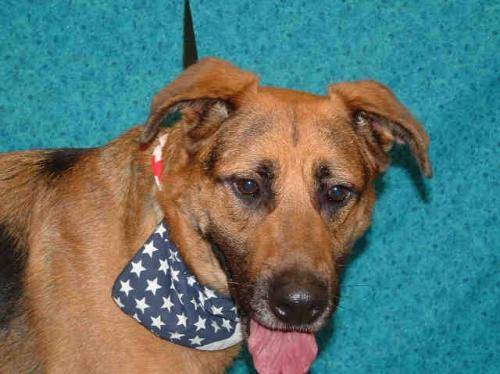

In [ ]:
from IPython.display import Image

image_check = '1006.jpg'

Image(image_path+image_check)

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./data/dogscats/test1/1006.jpg
Input image shape: (1, 224, 224, 3)


Using TensorFlow backend.


In [ ]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[2.2848633e-21 1.0000000e+00]]


In [ ]:
result= preds[0][0]
if result< preds[0][1]:
    print("It's a dog")
else:
    print("It's a cat")

It's a dog


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Get the weights

In [ ]:
# weights = model.get_weights()

In [ ]:
# model.set_weights(weights)

## Fine-tuning

In this particular case the model is already extremely accurate before fine tuning, so fine tuning doesn't help the model. 

Often for a model fine tuning can bump your accuracy by a few percent.


In [ ]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True
dense True
dense_1 True


In [ ]:
# model.set_weights(weights)

In [ ]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 2,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/2
646/646 [==============================] - 82s 127ms/step - loss: 0.0341 - accuracy: 0.9872 - val_loss: 0.0987 - val_accuracy: 0.9740
Epoch 2/2
646/646 [==============================] - 82s 127ms/step - loss: 0.0285 - accuracy: 0.9898 - val_loss: 0.0933 - val_accuracy: 0.9749


In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

71/71 [==============================] - 9s 123ms/step - loss: 0.0933 - accuracy: 0.9749
model accuracy: 0.9749119877815247
